This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 9: Friedman Drift 

* Consider Global Recurring Abrupt Drift:


In [1]:
import numpy as np
import pandas as pd
from spotRiver.evaluation.eval_bml import eval_bml_horizon, eval_oml_horizon, plot_bml_oml_horizon_predictions, plot_bml_oml_horizon_metrics
from spotRiver.utils.data_conversion import convert_to_df
from river import metrics as river_metrics, compose, feature_extraction, linear_model, preprocessing, stats
from river import stream as river_stream
from river import preprocessing as river_preprocessing
from river.datasets import synth
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing as preprocessing_sklearn
from sklearn import tree as sklearn_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import os
if not os.path.exists('./figures'):
    os.makedirs('./figures')

### Metric and Horizon

In [2]:
metric = mean_absolute_error
horizon = 7*24
k = 10
n_total = int(k*100_000)
p_1 = int(k*25_000)
p_2 = int(k*50_000)
position=(p_1, p_2)
n_train = 1_000
a = n_train + p_1 - 12
b = a + 12

### Data: Friedman-Drift

In [3]:
dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
     seed=123
)
data_dict = {key: [] for key in list(dataset.take(1))[0][0].keys()}
data_dict["y"] = []
for x, y in dataset.take(n_total):
    for key, value in x.items():
        data_dict[key].append(value)
    data_dict["y"].append(y)
df = pd.DataFrame(data_dict)
# Add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column
df.columns = [f"x{i}" for i in range(1, 11)] + ["y"]


In [4]:
train = df[:n_train]
test = df[n_train:]
target_column = "y"

### BML: Linear Regression

In [5]:
bml_lm = LinearRegression()
# Add a MinMaxScaler to the pipeline
bml_lm = make_pipeline(MinMaxScaler(), bml_lm)

In [6]:
df_eval_bml_lm, df_true_bml_lm = eval_bml_horizon(model = bml_lm,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, include_remainder=True, metric=metric)

/home/tbartzbe/.conda/envs/spot/lib/python3.11/site-packages/spotRiver/evaluation/eval_bml.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_eval.loc[batch_number + 1] = pd.Series(


### BML: Decision Tree Regressor

In [7]:
bml_tree = DecisionTreeRegressor(random_state=0)
# Add a MinMaxScaler to the pipeline
bml_tree = make_pipeline(MinMaxScaler(), bml_tree)
df_eval_bml_tree, df_true_bml_tree = eval_bml_horizon(model = bml_tree,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, include_remainder=True, metric=metric)

/home/tbartzbe/.conda/envs/spot/lib/python3.11/site-packages/spotRiver/evaluation/eval_bml.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_eval.loc[batch_number + 1] = pd.Series(


### OML: Linear Regression

In [8]:
oml_lm = preprocessing.StandardScaler()
oml_lm |= linear_model.LinearRegression()

df_eval_oml_lm, df_true_oml_lm = eval_oml_horizon(model=oml_lm, train=train, test=test, target_column="y", horizon=horizon, metric=metric)

### OML: HTR

In [9]:
htr_model =   (preprocessing.StandardScaler() | HoeffdingTreeRegressor())
df_eval_htr, df_true_htr = eval_oml_horizon(model=htr_model, train=train, test=test, target_column="y", horizon=horizon, oml_grace_period=100, metric=metric)

### OML: HATR

In [10]:
hatr_model =   (preprocessing.StandardScaler() | HoeffdingAdaptiveTreeRegressor())
df_eval_hatr, df_true_hatr = eval_oml_horizon(model=hatr_model, train=train, test=test, target_column="y", horizon=horizon, oml_grace_period=100,metric=metric)

Note: The following figures are used in the first edition of the book: (fig-first-edition-ch09_friedman_1_000_000_metrics and fig-first-edition-ch09_friedman_1_000_000_predictions).

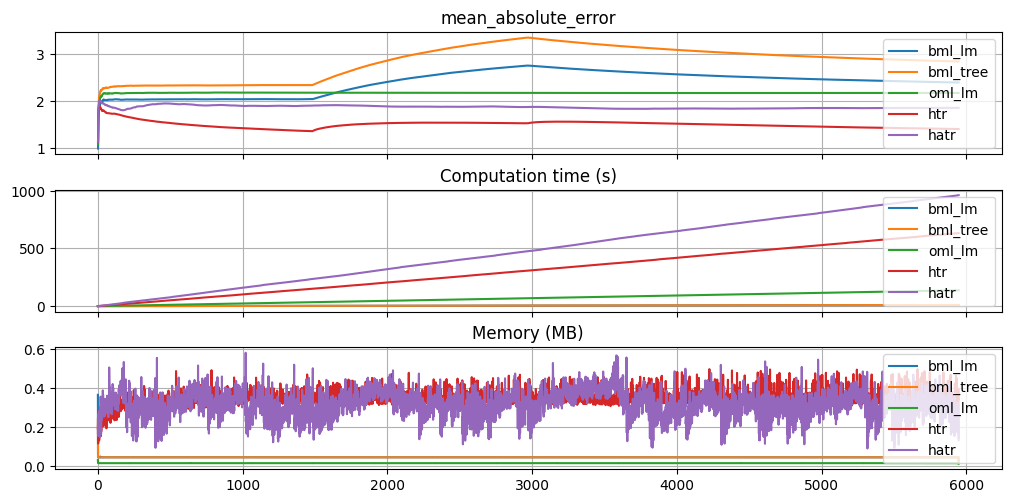

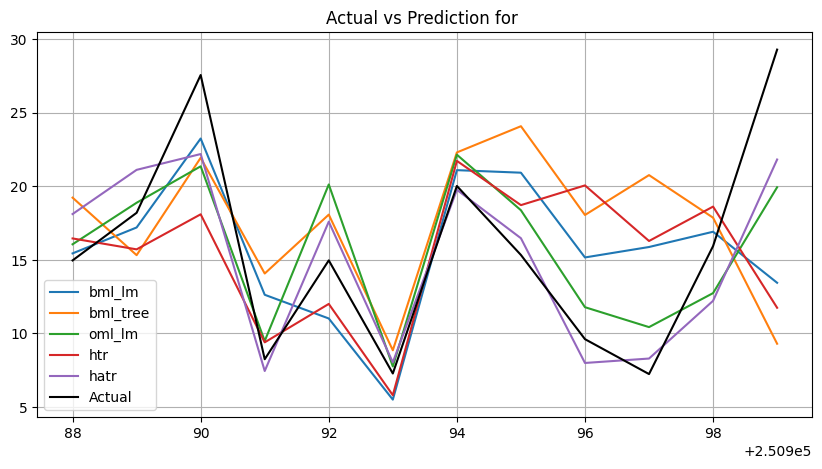

In [11]:
df_labels=["bml_lm", "bml_tree", "oml_lm", "htr", "hatr"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_lm, df_eval_bml_tree, df_eval_oml_lm, df_eval_htr, df_eval_hatr], log_y=False, log_x=False, df_labels=df_labels, cumulative=True, metric=metric, figsize=(10, 5), filename="./figures/first_edition_ch09_friedman_1_000_000_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_lm[a:b], df_true_bml_tree[a:b], df_true_oml_lm[a:b], df_true_htr[a:b], df_true_hatr[a:b]], target_column="y",  df_labels=df_labels, filename="./figures/1_edition_ch09_friedman_1_000_000_predictions.pdf")

## Changes in the 2nd edition of the book:

We will use spotRiver’s [convert_to_df](https://sequential-parameter-optimization.github.io/spotRiver/reference/spotRiver/utils/data_conversion/#spotRiver.utils.data_conversion.convert_to_df) method to convert the river data set to a pandas data frame. Then we add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.

This data generation is independently repeated for the training and test data sets, because the data sets are generated with concept drifts and the usual train-test split would not work.

In [12]:
import numpy as np
import pandas as pd
from spotRiver.evaluation.eval_bml import eval_bml_horizon, eval_oml_horizon, plot_bml_oml_horizon_predictions, plot_bml_oml_horizon_metrics
from spotRiver.utils.data_conversion import convert_to_df
from river import metrics as river_metrics, compose, feature_extraction, linear_model, preprocessing, stats
from river import stream as river_stream
from river import preprocessing as river_preprocessing
from river.datasets import synth
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing as preprocessing_sklearn
from sklearn import tree as sklearn_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import os
if not os.path.exists('./figures'):
    os.makedirs('./figures')

In [13]:
from river.datasets import synth
import pandas as pd
import numpy as np
from spotRiver.utils.data_conversion import convert_to_df

target_column = "y"

metric = mean_absolute_error
oml_grace_period=100
horizon = 7*24
k = 1
n_total = int(k*1_000_000)
p_1 = int(n_total/4)
p_2 = int(n_total/2)
position=(p_1, p_2)
a = oml_grace_period + p_1 - 12
b = a + 12

dataset_train = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=123
)

train = convert_to_df(dataset_train, n_total=n_total)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

In [14]:
dataset_test = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=124
)
test = convert_to_df(dataset_test, n_total=n_total)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

### BML: Linear Regression

In [15]:
bml_lm = LinearRegression()
# Add a MinMaxScaler to the pipeline
bml_lm = make_pipeline(MinMaxScaler(), bml_lm)

df_eval_bml_lm, df_true_bml_lm = eval_bml_horizon(model = bml_lm,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, include_remainder=True, metric=metric)

/home/tbartzbe/.conda/envs/spot/lib/python3.11/site-packages/spotRiver/evaluation/eval_bml.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_eval.loc[batch_number + 1] = pd.Series(


### BML: Decision Tree Regressor

In [16]:
bml_tree = DecisionTreeRegressor(random_state=0)
# Add a MinMaxScaler to the pipeline
bml_tree = make_pipeline(MinMaxScaler(), bml_tree)
df_eval_bml_tree, df_true_bml_tree = eval_bml_horizon(model = bml_tree,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, include_remainder=True, metric=metric)

/home/tbartzbe/.conda/envs/spot/lib/python3.11/site-packages/spotRiver/evaluation/eval_bml.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_eval.loc[batch_number + 1] = pd.Series(


### OML: Linear Regression

In [17]:
oml_lm = preprocessing.StandardScaler()
oml_lm |= linear_model.LinearRegression()

df_eval_oml_lm, df_true_oml_lm = eval_oml_horizon(model=oml_lm, train=train, test=test, target_column="y", horizon=horizon, metric=metric)

### OML: HTR

In [18]:
htr_model =   (preprocessing.StandardScaler() | HoeffdingTreeRegressor())
df_eval_htr, df_true_htr = eval_oml_horizon(model=htr_model, train=train, test=test, target_column="y", horizon=horizon, oml_grace_period=oml_grace_period, metric=metric)

### OML: HATR

In [19]:
hatr_model =   (preprocessing.StandardScaler() | HoeffdingAdaptiveTreeRegressor())
df_eval_hatr, df_true_hatr = eval_oml_horizon(model=hatr_model, train=train, test=test, target_column="y", horizon=horizon, oml_grace_period=oml_grace_period,metric=metric)

Note: The following figures are used in the 2nd edition of the book: (fig-ch09_friedman_1_000_000_metrics and fig-ch09_friedman_1_000_000_predictions).

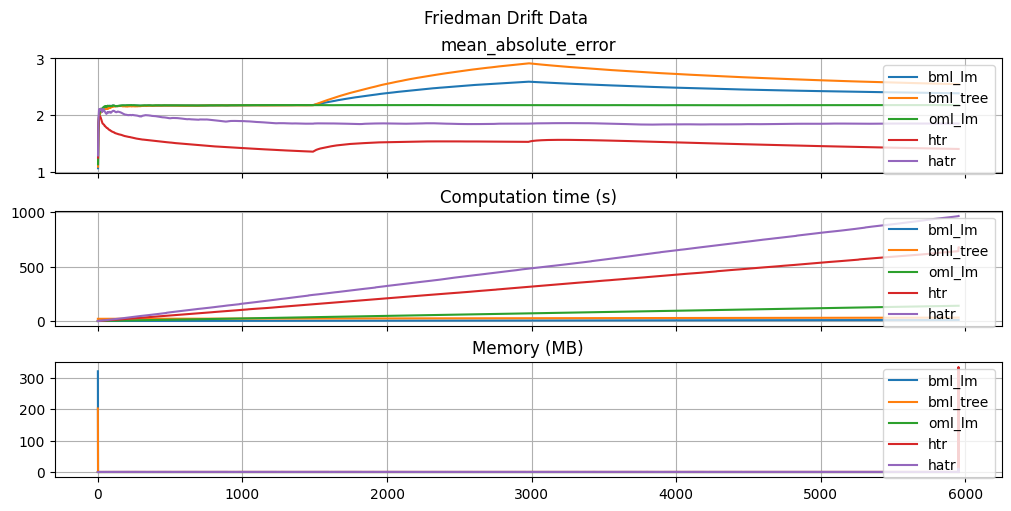

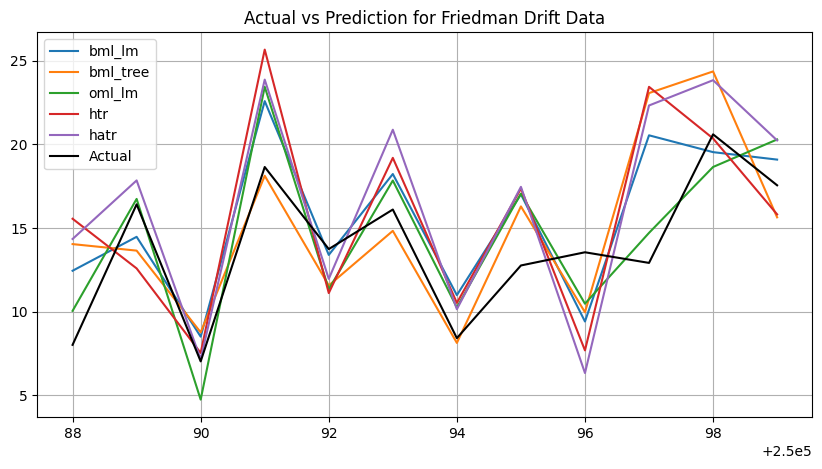

In [20]:
df_labels=["bml_lm", "bml_tree", "oml_lm", "htr", "hatr"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_lm, df_eval_bml_tree, df_eval_oml_lm, df_eval_htr, df_eval_hatr], log_y=False, log_x=False, df_labels=df_labels, cumulative=True, metric=metric, figsize=(10, 5), title="Friedman Drift Data", filename="./figures/ch09_friedman_1_000_000_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_lm[a:b], df_true_bml_tree[a:b], df_true_oml_lm[a:b], df_true_htr[a:b], df_true_hatr[a:b]], target_column="y",  df_labels=df_labels, title="Friedman Drift Data", filename="./figures/ch09_friedman_1_000_000_predictions.pdf")

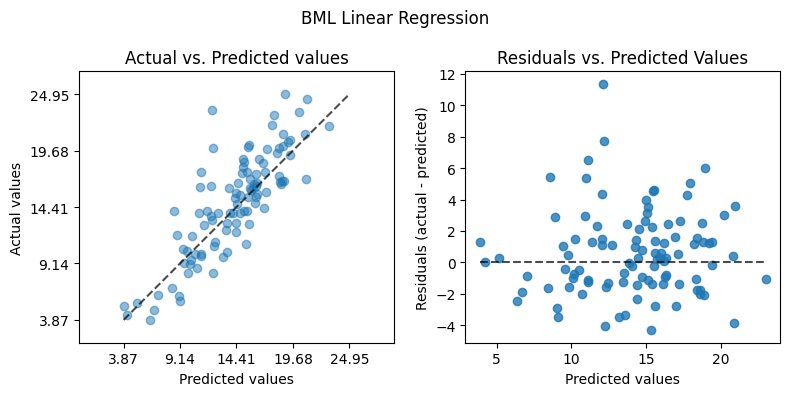

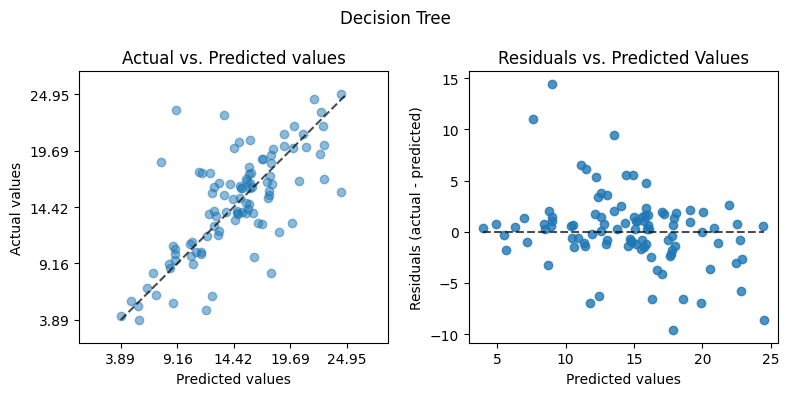

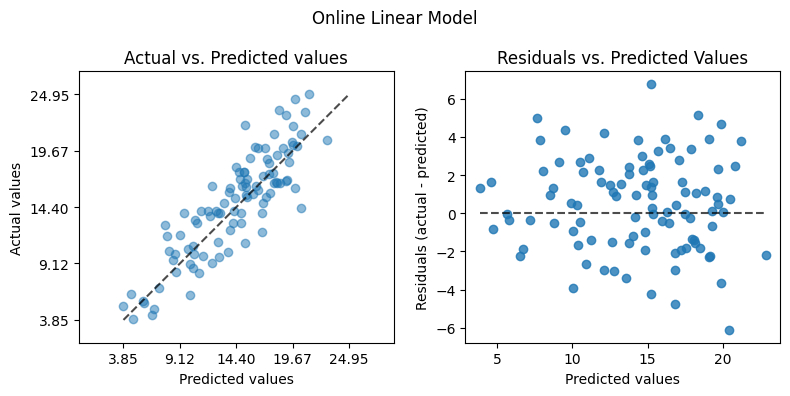

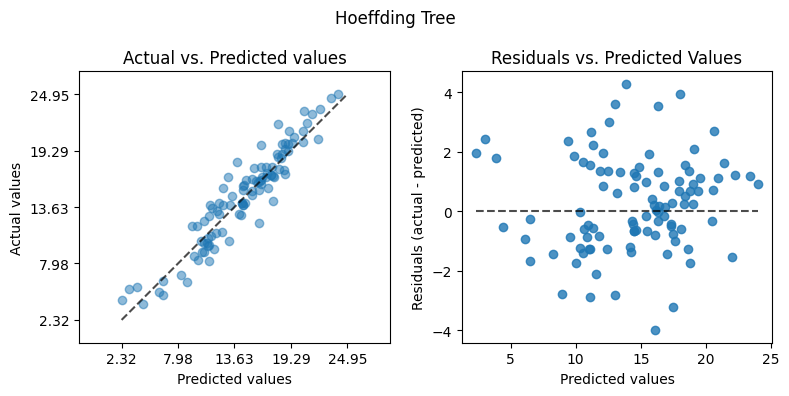

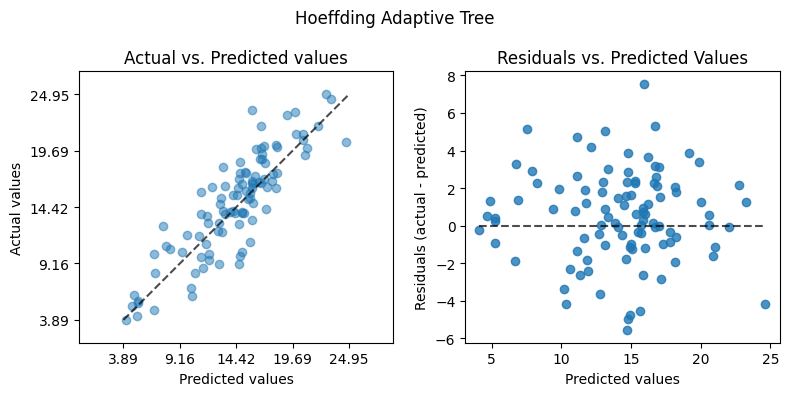

In [21]:
from spotPython.plot.validation import plot_actual_vs_predicted

plot_actual_vs_predicted(y_test=df_true_bml_lm[target_column], y_pred=df_true_bml_lm["Prediction"], title="BML Linear Regression", filename="./figures/ch09_friedman_1_000_000_bml_lm.pdf")
plot_actual_vs_predicted(y_test=df_true_bml_tree[target_column], y_pred=df_true_bml_tree["Prediction"], title="Decision Tree", filename="./figures/ch09_friedman_1_000_000_bml_tree.pdf")
plot_actual_vs_predicted(y_test=df_true_oml_lm[target_column], y_pred=df_true_oml_lm["Prediction"], title="Online Linear Model", filename="./figures/ch09_friedman_1_000_000_oml_lm.pdf")
plot_actual_vs_predicted(y_test=df_true_htr[target_column], y_pred=df_true_htr["Prediction"], title="Hoeffding Tree", filename="./figures/ch09_friedman_1_000_000_htr.pdf")
plot_actual_vs_predicted(y_test=df_true_hatr[target_column], y_pred=df_true_hatr["Prediction"], title="Hoeffding Adaptive Tree", filename="./figures/ch09_friedman_1_000_000_hatr.pdf")